In [13]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier

# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error#, accuracy
from sklearn.linear_model import BayesianRidge

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

In [19]:
predDimension = "kbs"
v_names_train = np.loadtxt("train_names.csv", dtype=str)
train_names = [s[:-4] for s in v_names_train]
v_names_test = np.loadtxt("test_names.csv", dtype=str)

video_features = ["WIDTH", "HEIGHT", "SPATIAL_COMPLEXITY", "TEMPORAL_COMPLEXITY", "COLOR_COMPLEXITY", "ORIG_SIZE", "ORIG_KBS"] 
config_features = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", 
                "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", 
                "mbtree", "qpmax", "aq-mode"]
config_features_categorical = ['analyse', 'me', 'direct', 'deblock', 'b_pyramid', 'b_adapt', 'weightb', 'open_gop', 'scenecut', 'rc_lookahead']

In [11]:
df = pd.read_csv("all_features.csv")

for c in config_features_categorical:
    df[c], _ = pd.factorize(df[c])
    
df.head()

,configurationID,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,...,kbs,etime,FILENAME,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,COLOR_COMPLEXITY,ORIG_SIZE,ORIG_KBS
0,1,0,1,0,0,0,0,0,16,0,...,161.07,2.14,Animation_1080P-01b3,1920,1080,0.098,0.004,0.005,1866272605,745763.278
1,101,1,2,1,1,1,6,1,16,1,...,93.57,3.40,Animation_1080P-01b3,1920,1080,0.098,0.004,0.005,1866272605,745763.278
2,102,1,2,1,1,1,6,1,16,1,...,63.87,2.71,Animation_1080P-01b3,1920,1080,0.098,0.004,0.005,1866272605,745763.278
3,103,1,2,0,2,2,6,1,16,1,...,65.37,2.78,Animation_1080P-01b3,1920,1080,0.098,0.004,0.005,1866272605,745763.278
4,104,1,16,1,1,1,6,1,24,1,...,87.27,2.74,Animation_1080P-01b3,1920,1080,0.098,0.004,0.005,1866272605,745763.278


In [23]:
df["video_category"] = df.FILENAME.str.split("_", expand=True)[0] #.unique()

In [26]:
df["video_category"].unique()

15

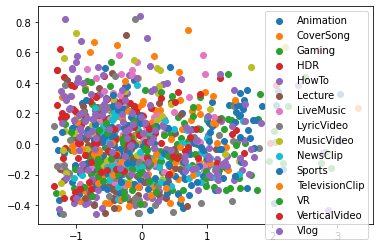

In [41]:
train_df = df[df.FILENAME.isin(train_names)]
video_data = train_df[video_features + ["video_category"]].drop_duplicates()
pca = decomposition.PCA(n_components=2)
X_red = pca.fit_transform(video_data[["SPATIAL_COMPLEXITY", "TEMPORAL_COMPLEXITY", "COLOR_COMPLEXITY"]])
y = video_data["video_category"]

colors = ['navy', 'turquoise', 'darkorange']

plt.set_cmap("tab20c")

# for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
for i, category in enumerate(video_data["video_category"].unique()):
    plt.scatter(X_red[y == category, 0], X_red[y == category, 1], lw=1, label=category)
    
plt.legend(loc="best", shadow=False, scatterpoints=1)

In [4]:
from catboost import CatBoostRegressor, Pool

# we separate the list of videos into a training (i.e. offline) set and a test set (i.e. online)
train_ind, test_ind = train_test_split([k for k in range(len(v_names_train))], test_size = 0.25, random_state=0)
# training set indexes
# train_index = [v[:-4] for v in v_names_train]
train_index = [v_names_train[k][:-4] for k in train_ind]
# test set indexes
test_index = [v_names_train[k][:-4] for k in test_ind]
print(len(train_index), len(test_index))

train_df = df[df.FILENAME.isin(train_index)]
val_df = df[df.FILENAME.isin(test_index)]

X_train = train_df[video_features + config_features].to_numpy()
y_train = np.array(train_df[predDimension] / train_df["ORIG_KBS"]).reshape(-1, 1)
# y_train = np.array(train_df[predDimension]).reshape(-1, 1)
X_val = val_df[video_features + config_features].to_numpy()
y_val = np.array(val_df[predDimension] / val_df["ORIG_KBS"]).reshape(-1, 1)
# y_val = np.array(val_df[predDimension]).reshape(-1, 1)

# classes = 10 ** np.linspace(np.log10(0.001), np.log10(1.0), 50)
# y_train = ((train_df[predDimension] / train_df["ORIG_KBS"]).to_numpy()[:, np.newaxis] < classes.reshape(1, -1)).argmax(axis=1).reshape(-1, 1)
# y_val = ((val_df[predDimension] / val_df["ORIG_KBS"]).to_numpy()[:, np.newaxis] < classes.reshape(1, -1)).argmax(axis=1).reshape(-1, 1)

# obj_scaler = StandardScaler()
# y_train = obj_scaler.fit_transform(y_train)
# y_val = obj_scaler.transform(y_val)

train_pool = Pool(X_train, 
                  y_train)
test_pool = Pool(X_val, y_val)

787 263


In [5]:
model = CatBoostRegressor(verbose=False)
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

randomized_search_result = model.randomized_search(grid,
                                                   X=X_train,
                                                   y=y_train,
                                                   plot=True,
                                                  verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.002478649267
bestIteration = 999


bestTest = 0.00246727392
bestIteration = 999


bestTest = 0.002670646136
bestIteration = 999


bestTest = 0.00163674779
bestIteration = 999


bestTest = 0.002699270126
bestIteration = 999


bestTest = 0.001663713255
bestIteration = 999


bestTest = 0.00167506544
bestIteration = 999


bestTest = 0.000793572909
bestIteration = 999


bestTest = 0.001510113894
bestIteration = 999


bestTest = 0.0008254482138
bestIteration = 999



In [6]:
model.score(test_pool)

0.7709500390900006

In [15]:
# specify the training parameters 
model2 = CatBoostRegressor(iterations=50, 
#                           depth=10, 
#                           learning_rate=1, 
#                           grow_policy="Lossguide",
                          loss_function='RMSEWithUncertainty',
                           posterior_sampling=True,
                          verbose=False)
#train the model
model2.fit(train_pool, eval_set=test_pool, use_best_model=True)
# make the prediction using the resulting model

preds = model2.virtual_ensembles_predict(X_val, prediction_type='TotalUncertainty', 
                                        virtual_ensembles_count=10)
mean_preds = preds[:,0] # mean values predicted by a virtual ensemble
knowledge = preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data = preds[:,2] # average estimated data uncertainty

In [21]:
knowledge.max(), knowledge.argmax(), data.max(), data.argmax()

(8.626019375427949e-06, 34484, 0.006375417779917482, 34484)

In [28]:
np.partition([3,4,2,1], -3)

array([1, 2, 4, 3])

In [8]:
model2.score(test_pool)

0.7570141272805788

In [ ]:
# we separate the list of videos into a training (i.e. offline) set and a test set (i.e. online)
train_ind, test_ind = train_test_split([k for k in range(len(v_names_train))], test_size = 0.25, random_state=0)
# training set indexes
# train_index = [v[:-4] for v in v_names_train]
train_index = [v_names_train[k][:-4] for k in train_ind]
# test set indexes
test_index = [v_names_train[k][:-4] for k in test_ind]
print(len(train_index), len(test_index))

train_df = df[df.FILENAME.isin(train_index)]
val_df = df[df.FILENAME.isin(test_index)]

X_train = train_df[video_features + config_features].to_numpy()
# y_train = np.array(train_df[predDimension] / train_df["ORIG_KBS"]).reshape(-1, 1)
# y_train = np.array(train_df[predDimension]).reshape(-1, 1)
X_val = val_df[video_features + config_features].to_numpy()
# y_val = np.array(val_df[predDimension] / val_df["ORIG_KBS"]).reshape(-1, 1)
# y_val = np.array(val_df[predDimension]).reshape(-1, 1)

classes = 10 ** np.linspace(np.log10(0.001), np.log10(1.0), 50)
y_train = ((train_df[predDimension] / train_df["ORIG_KBS"]).to_numpy()[:, np.newaxis] < classes.reshape(1, -1)).argmax(axis=1).reshape(-1, 1)
y_val = ((val_df[predDimension] / val_df["ORIG_KBS"]).to_numpy()[:, np.newaxis] < classes.reshape(1, -1)).argmax(axis=1).reshape(-1, 1)

# obj_scaler = StandardScaler()
# y_train = obj_scaler.fit_transform(y_train)
# y_val = obj_scaler.transform(y_val)

In [ ]:
clf = RandomForestClassifier(max_depth=None, min_samples_leaf=2, n_estimators=200, n_jobs=1)
clf.fit(X_train, y_train.ravel())
clf.score(X_val, y_val)
# y_pred_val = clf.predict(X_val)
# accuracy(y_val, y_pred_val)
# performance_ratio(val_df, y_pred_val)

In [ ]:
def print_val_error(y_val, y_pred_val, scaler):
    mse = mean_squared_error(y_val, y_pred_val)
    mae_rescaled = mean_absolute_error(scaler.inverse_transform(y_val), scaler.inverse_transform(y_pred_val))
    mae_kbs = mean_absolute_error(scaler.inverse_transform(y_val).ravel()*val_df["ORIG_KBS"].to_numpy(), scaler.inverse_transform(y_pred_val).ravel()*val_df["ORIG_KBS"].to_numpy())
    print("val error", mse, mae_rescaled, mae_kbs)

In [ ]:
rgr = BayesianRidge(normalize=True)
rgr.fit(X_train, y_train.ravel())
# rgr.score(X_val, y_val.ravel())
y_pred_train = rgr.predict(X_train)
y_pred_test = rgr.predict(X_val)
print("train error: ", mean_squared_error(y_train, y_pred_train))
print_val_error(y_val, y_pred_test, obj_scaler)

In [ ]:
X_red = []
y_red = []

for i in np.random.choice(X_train.shape[0], 1000, replace=False):
    X_red.append(X_train[i])
    y_red.append(y_train[i])
    
X_red = np.array(X_red)
y_red = np.array(y_red)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1)

rgr = GaussianProcessRegressor(kernel, normalize_y=False)  # , max_iter=500
rgr.fit(X_red, y_red.ravel())
# rgr.score(X_val, y_val.ravel())
y_pred_train = rgr.predict(X_train)
y_pred_test = rgr.predict(X_val)
print("train error: ", mean_squared_error(y_train, y_pred_train))
print_val_error(y_val, y_pred_test, obj_scaler)

In [ ]:
np.histogram(train_df["kbs"] / train_df["ORIG_KBS"], bins=10 ** np.linspace(np.log10(0.001), np.log10(1.0), 50), range=(0,1), density=False)

In [ ]:
b = [0.0, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
np.histogram(train_df["kbs"] / train_df["ORIG_KBS"], bins="sturges", range=(0,1), density=False)

In [ ]:
np.histogram(np.log(train_df["size"] / train_df["ORIG_SIZE"]), bins=50)

In [ ]:
from alipy.experiment.al_experiment import AlExperiment

al = AlExperiment(X_train, y_train, stopping_criteria='num_of_queries', stopping_value=50,)
al.split_AL()
al.set_query_strategy(strategy="QueryInstanceUncertainty", measure='least_confident')
al.set_performance_metric('accuracy_score')
al.start_query(multi_thread=True)
al.plot_learning_curve()